In [1]:
import dask.dataframe as dd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
current_year = datetime.now().year

In [3]:
def load_data(filepath: str):
    """Загружаем CSV файл в Dask DataFrame"""
    data = dd.read_csv(filepath, assume_missing=True)
    data = data[["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs", "price"
                       ]]
    return data

In [4]:
def preprocess_partition(batch):
    """Обрабатываем каждую партицию: дропаем пропуски и дубликаты, делаем новые фичи"""
    batch = batch.dropna()
    batch = batch.drop_duplicates()
    batch["power_per_litre"] = batch["engine_power"] / batch["engine_volume"]
    # мощность двигателя относительно объема в литрах
    # насколько эффективно используется объем двигателя для генерации мощности

    batch['mean_mileage_per_year'] = batch['mileage'] / (current_year - batch['year']) 
    # средний пробег в год
    
    return batch

In [5]:
def split_data(df: dd.DataFrame):
    """Разделяет данные на обучающую и тестовую выборки"""
    train_df = df.partitions[0:17]
    test_df = df.partitions[18]
    return train_df, test_df

In [6]:
def train_catboost(filepath: str):
    """Функция обучения CatBoost по партициям"""
    # Параметры модели
    params = {
    'learning_rate': 0.05,
    'n_estimators': 400
    }
    # Инициализируем модель
    model = CatBoostRegressor(
        **params, verbose=50
    )

    partitions = filepath.to_delayed()

    for i, partition in enumerate(partitions):
        partition = partition.compute()  # Загружаем партицию в память (compute только для текущей)
        partition = preprocess_partition(partition)  # Обрабатываем партицию

        # Категориальные признаки
        cat_features = [x for x in partition.columns if partition[x].dtype=='string[pyarrow]']
        partition[cat_features] = partition[cat_features].apply(lambda x: x.astype('category'))

        feature_train = partition.drop(columns=["price"])
        target_train = partition["price"]

        if i == 0:
            model.fit(feature_train, target_train, cat_features=cat_features)  # Первый батч - обучаем модель с нуля
        else:
            model.fit(feature_train, target_train, cat_features=cat_features, 
                      init_model=model)  # Следующие партиции - дообучаем модель

    return model



In [7]:
def predict_in_partitions(model, test_df):
    """Функция для прогнозов на тестовых партициях"""
    predictions = []
    actuals = []

    for partition in test_df.to_delayed():
        batch = partition.compute()
        batch = preprocess_partition(batch)
        X_batch = batch.drop(columns=["price"])
        y_batch = batch["price"]

        y_pred = model.predict(X_batch)
        predictions.append(y_pred)
        actuals.append(y_batch.to_numpy())

    return np.concatenate(predictions), np.concatenate(actuals)

In [8]:
def calculate_metrics(y_pred, y_true):
    """Функция для расчета метрик"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = (np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print("Оценка тестового множества модели CatBoost:")
    print('MSE: {:.2f}'.format(mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('R2: {:.2f}'.format(r2))

In [9]:
file = "dataset_with_electro.csv"  # Путь к исходным данным

df = load_data(file)
train_df, test_df = split_data(df)

# Обучаем модель
print("🔄 Обучаем CatBoost на обучающих данных...")
model = train_catboost(train_df)

print("🔄 Делаем предсказания...")
y_preds, y_true = predict_in_partitions(model, test_df)

🔄 Обучаем CatBoost на обучающих данных...


0:	learn: 905894.8885372	total: 142ms	remaining: 14.1s
50:	learn: 268212.4022338	total: 1.92s	remaining: 1.85s
99:	learn: 218453.8892182	total: 3.6s	remaining: 0us
0:	learn: 456320.8008146	total: 21.7ms	remaining: 2.15s
50:	learn: 278782.0144567	total: 1.52s	remaining: 1.46s
99:	learn: 215324.2823234	total: 3.46s	remaining: 0us
0:	learn: 456545.6127746	total: 29.8ms	remaining: 2.95s
50:	learn: 266934.8199686	total: 1.72s	remaining: 1.65s
99:	learn: 233867.4051439	total: 3.41s	remaining: 0us
0:	learn: 438435.4074838	total: 30.5ms	remaining: 3.02s
50:	learn: 277777.6871960	total: 1.73s	remaining: 1.66s
99:	learn: 234407.4158283	total: 3.45s	remaining: 0us
0:	learn: 366797.3265619	total: 33.2ms	remaining: 3.29s
50:	learn: 263964.7110672	total: 1.55s	remaining: 1.49s
99:	learn: 222436.7279479	total: 3.2s	remaining: 0us
0:	learn: 375833.6798246	total: 32.8ms	remaining: 3.25s
50:	learn: 252219.4496715	total: 1.82s	remaining: 1.75s
99:	learn: 217687.7207725	total: 3.47s	remaining: 0us
0:	lear

In [10]:
# Оцениваем модель
print("🔄 Оцениваем модель на тестовых данных...")
calculate_metrics(y_preds, y_true)

🔄 Оцениваем модель на тестовых данных...
Оценка тестового множества модели CatBoost:
MSE: 629380704651.75
RMSE: 793335.18
MAE: 186547.15
MAPE: 0.43
R2: 0.52


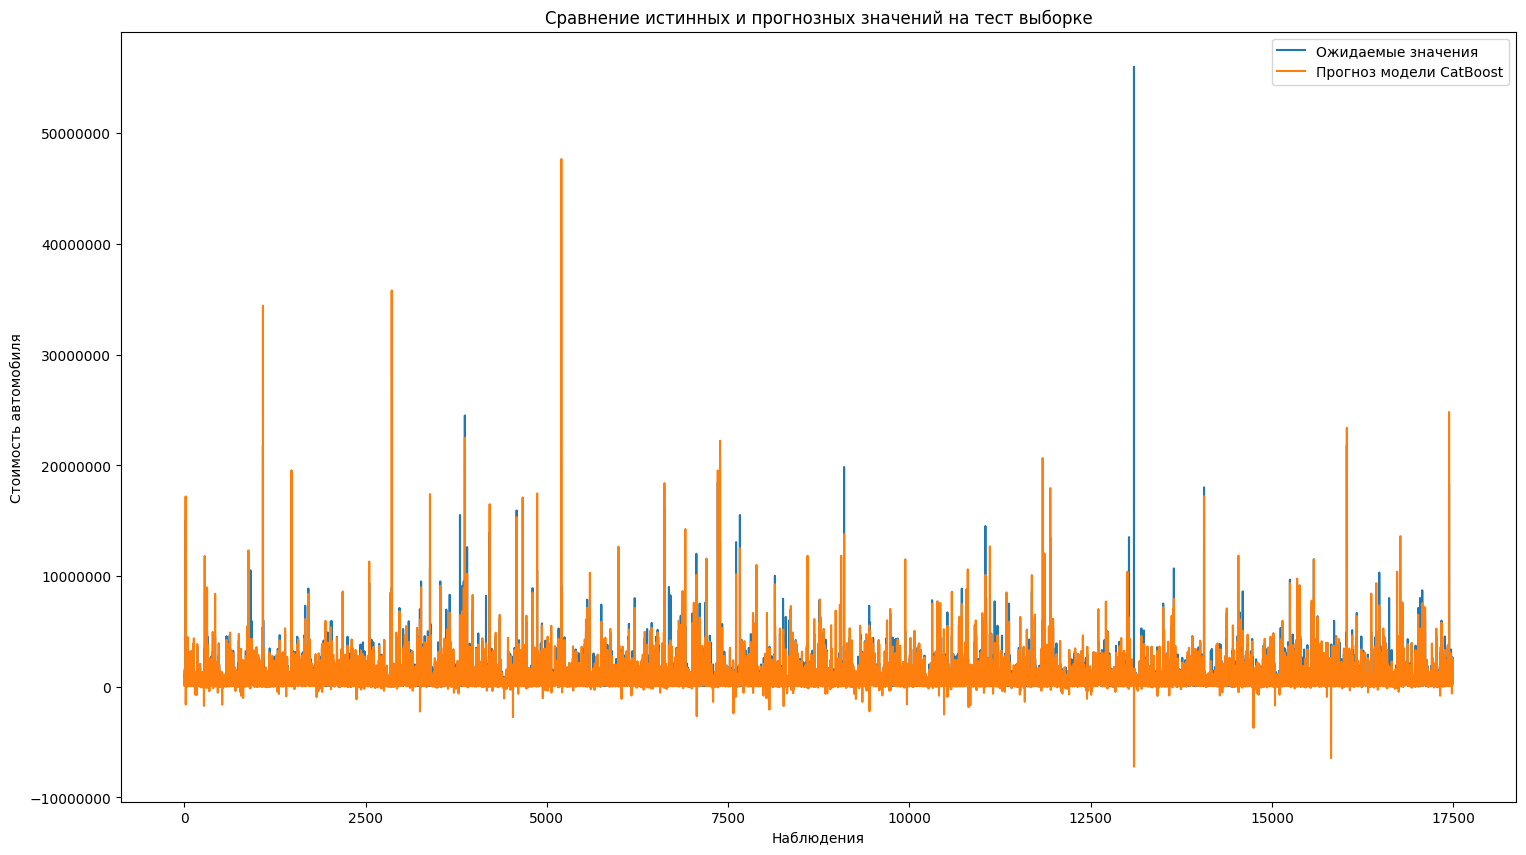

In [11]:
plt.figure(figsize=(18,10))
plt.title("Сравнение истинных и прогнозных значений на тест выборке")
plt.plot(y_true, label = 'Ожидаемые значения')
plt.plot(y_preds, label = 'Прогноз модели CatBoost')
plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [12]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs", 'power_per_litre', 'mean_mileage_per_year'
                       ]).sort_values()

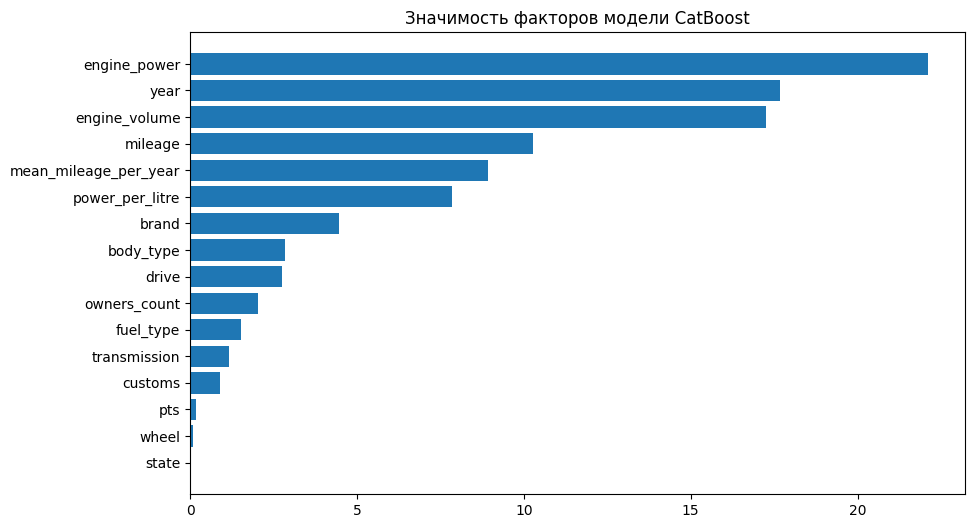

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()